# Final Project - Reinforcements Learning
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Avraham Raviv, 204355390
<br>
Student 2: Yevgeni Berkovitch, 317079234
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban

!imageio_download_bin ffmpeg

# Imports

In [ ]:
import random
import time

import numpy as np
import matplotlib.pyplot as plt

import base64
import imageio
from pyvirtualdisplay import Display
from IPython.display import HTML

import gym
from gym import error, spaces, utils
from soko_pap import *

from collections import deque
from queue import PriorityQueue

from keras.models import Sequential
from keras.layers import Dense

In [ ]:
%matplotlib inline

In [ ]:
imageio.plugins.ffmpeg.download()

In [ ]:
from gym import logger as gymlogger
gymlogger.set_level(40) # error only

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return HTML(tag)

# Solution

In [ ]:
class SOK_Agent:
    def __init__(self):
        # Construct DQN models
        self.state_size = (25,)
        self.action_size = 8
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.batch_size = 8

        # Replay buffers
        self.replay_buffer = deque(maxlen=1500)
        self.prioritized_replay_buffer = deque(maxlen=500)
        self.prioritized_replay_batch = 50

        # Hyperparameters
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.2
        self.epsilon_decay = 0.999
        self.epsilon_update_rate = 10
        self.replay_rate = 10
        self.update_beta = 0.99

        self.verbosity = 100

    def _build_model(self):
        model = Sequential()
        model.add(Dense(25, input_shape=self.state_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='huber', optimizer="adam")
        return model

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append([state, action, reward, next_state, done])

    def copy_to_prioritized_buffer(self, n):
        for i in range(n):
            self.prioritized_replay_buffer.append(self.replay_buffer[-1-i])

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self):
        minibatch = random.sample(self.replay_buffer, self.batch_size//2)
        minibatch.extend(random.sample(self.prioritized_replay_buffer, self.batch_size//2))

        states = np.zeros((self.batch_size, self.state_size[0]))
        targets = np.zeros((self.batch_size, self.action_size))
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            states[i] = state
            targets[i] = self.model.predict(state, verbose=0)
            if done:
                targets[i][action] = reward
            else:
                max_action = np.argmax(self.model.predict(next_state)[0])
                targets[i][action] = reward + self.gamma*self.target_model.predict(next_state)[0][max_action]

        self.model.fit(states, targets, epochs=10, verbose=0)

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon * self.epsilon_decay

    def update_target_model(self):
        model_w = self.model.get_weights()
        target_model_w = self.target_model.get_weights()
        updated_target_model_w = []
        for i in range(len(model_w)):
            updated_target_model_w.append(self.update_beta*target_model_w[i] + (1-self.update_beta)*model_w[i])
        self.target_model.set_weights(updated_target_model_w)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
def process_frame(frame):
    f = frame[16:96, 16:96, 0]
    f = f.reshape(5, 16, 5, 16).max(axis=(1, 3))
    f = f.flatten()
    f = f / 255
    return np.expand_dims(f, axis=0)

## Training

In [ ]:
max_episodes = 10000
max_steps = 500

def init_sok():
    random.seed(2)
    sok = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1)
    sok.set_maxsteps(max_steps)
    return sok

In [ ]:
agent = SOK_Agent()
successes_before_train = 5
successful_episodes = 0
continuous_successes_goal = 10
continuous_successes = 0

steps_per_episode = []

for e in range(max_episodes):
    if continuous_successes >= continuous_successes_goal:
        print("Agent training finished!")
        break

    print("Episode: %d" % (e+1))

    sok = init_sok()
    state = process_frame(sok.get_image('rgb_array'))
    random.seed(e)

    for step in range(sok.max_steps):
        action = agent.act(state)
        if action < 4:
            next_state, reward, done, _ = sok.step(action+1)
        else:
            next_state, reward, done, _ = sok.step(action+5)
        next_state = process_frame(next_state)

        if reward > 0:
            reward = 1.0

        agent.remember(state, action, reward, next_state, done)

        state = next_state

        if successful_episodes >= successes_before_train:
            if (step+1) % agent.replay_rate == 0:
                agent.replay()
                agent.update_target_model()
                agent.update_epsilon()
            if (step+1) % agent.verbosity == 0:
                print("Episode %d Steps %d Epsilon %.4f" % (e+1, step+1, agent.epsilon))

        if done:
            if 3 in sok.room_state:
                successful_episodes += 1
                continuous_successes += 1
                print("SOLVED! Episode %d Steps: %d Epsilon %.4f" % (e+1, step+1, agent.epsilon))
                agent.copy_to_prioritized_buffer(min(agent.prioritized_replay_batch, step+1))
            else:
                continuous_successes = 0

            steps_per_episode.append(step+1)
            agent.save("exp1_episode%d.h5" % (e+1))

            break

Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
SOLVED! Episode 23 Steps: 438 Epsilon 1.0000
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
SOLVED! Episode 29 Steps: 488 Epsilon 1.0000
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
SOLVED! Episode 57 Steps: 466 Epsilon 1.0000
Episode: 58
Episode: 59
SOLVED! Episode 59 Steps: 454 Epsilon 1.0000
Episode: 60
Episode: 61
Episode: 62
Episode: 63
SOLVED! Episode 63 Steps: 226 Epsilon 1.0000
Episode: 64
Episode 64 Steps

Episode 102 Steps 300 Epsilon 0.1999
Episode 102 Steps 400 Epsilon 0.1999
Episode 102 Steps 500 Epsilon 0.1999
Episode: 103
Episode 103 Steps 100 Epsilon 0.1999
Episode 103 Steps 200 Epsilon 0.1999
Episode 103 Steps 300 Epsilon 0.1999
SOLVED! Episode 103 Steps: 318 Epsilon 0.1999
Episode: 104
Episode 104 Steps 100 Epsilon 0.1999
Episode 104 Steps 200 Epsilon 0.1999
Episode 104 Steps 300 Epsilon 0.1999
Episode 104 Steps 400 Epsilon 0.1999
Episode 104 Steps 500 Epsilon 0.1999
Episode: 105
Episode 105 Steps 100 Epsilon 0.1999
Episode 105 Steps 200 Epsilon 0.1999
SOLVED! Episode 105 Steps: 251 Epsilon 0.1999
Episode: 106
Episode 106 Steps 100 Epsilon 0.1999
SOLVED! Episode 106 Steps: 157 Epsilon 0.1999
Episode: 107
Episode 107 Steps 100 Epsilon 0.1999
Episode 107 Steps 200 Epsilon 0.1999
Episode 107 Steps 300 Epsilon 0.1999
Episode 107 Steps 400 Epsilon 0.1999
Episode 107 Steps 500 Epsilon 0.1999
Episode: 108
Episode 108 Steps 100 Epsilon 0.1999
Episode 108 Steps 200 Epsilon 0.1999
Episode

SOLVED! Episode 157 Steps: 9 Epsilon 0.1999
Agent training finished!


## Charts

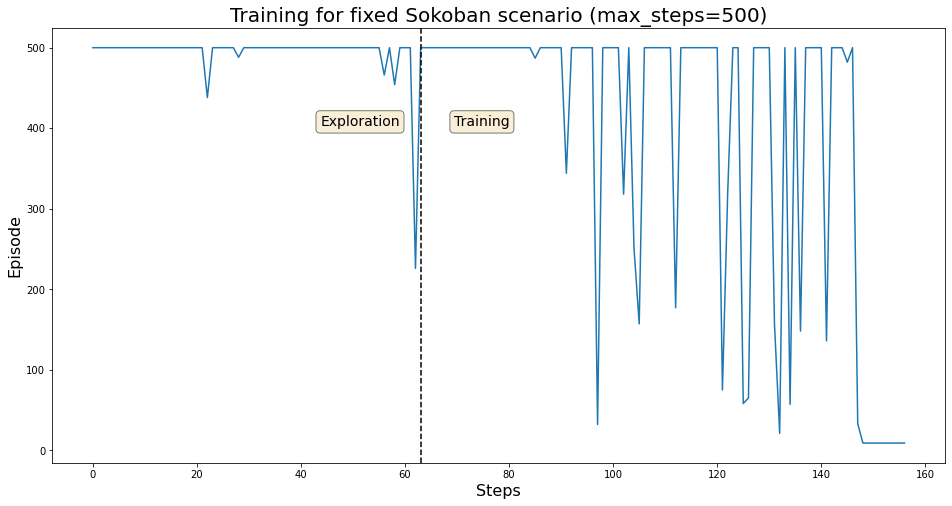

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(list(range(len(steps_per_episode))), steps_per_episode)
plt.title("Training for fixed Sokoban scenario (max_steps=500)", fontsize=20)
plt.xlabel("Steps", fontsize=16)
plt.ylabel("Episode", fontsize=16)
plt.axvline(63, color='k', linestyle='--', label='Start')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.30, 0.8, "Exploration", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.45, 0.8, "Training", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
plt.show()

## Demo

#### Halfway Training - Epsilon = 0.3

In [ ]:
sok = init_sok()
agent.load("exp1_episode110.h5")
sok.epsilon = 0.3

start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'

state = sok.get_image('rgb_array')

with imageio.get_writer(video_filename, fps=10) as video:
    while (iter < 10) or not done:
        time_passed = int(time.time() - start_time)
        if done or time_passed > 3:
            break
        iter +=1
        action = agent.act(process_frame(state))

        if action < 4:
            action += 1
        else:
            action += 5

        state, reward, done, info = sok.step(action)
        video.append_data(sok.render(mode='rgb_array'))

embed_mp4(video_filename)

#### Finished Training - Epsilon = 0.0

In [ ]:
sok = init_sok()
agent.load("exp1_episode157.h5")
sok.epsilon = 0.0

start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'

state = sok.get_image('rgb_array')

with imageio.get_writer(video_filename, fps=3) as video:
    while (iter < 10) or not done:
        time_passed = int(time.time() - start_time)
        if done or time_passed > 3:
            break
        iter +=1
        action = agent.act(process_frame(state))

        if action < 4:
            action += 1
        else:
            action += 5

        state, reward, done, info = sok.step(action)
        video.append_data(sok.render(mode='rgb_array'))

embed_mp4(video_filename)